In [36]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import csv
from textblob import TextBlob
import pandas as pd
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
import os
from os.path import join
import datetime as dt
from scipy.stats.stats import pearsonr
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.cross_validation import StratifiedKFold
import itertools
from scipy.stats import kendalltau
import random
import nltk
random.seed(123)

In [37]:
plt.style.use('ggplot')

In [38]:
data = pd.read_csv('winemag-data_first150k.csv')
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


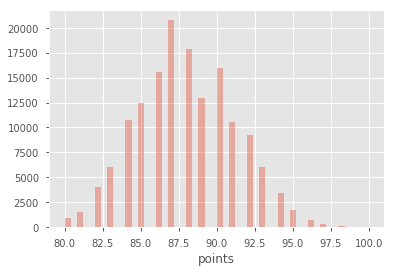

In [39]:
sns.distplot(data.points, kde=False)

In [40]:
def GoodRating(row):
    if row['points'] >= 89:
        val = 1
    else:
        val = 0
    return(val)
data['Good'] = data.apply(GoodRating, axis=1)
data.head()
#data.shape (15k,12)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Good
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1


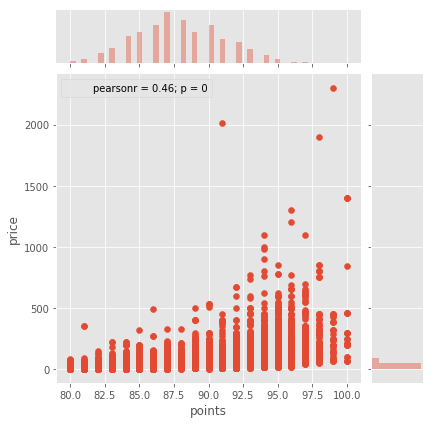

In [6]:
sns.jointplot(x='points', y='price', data=data)

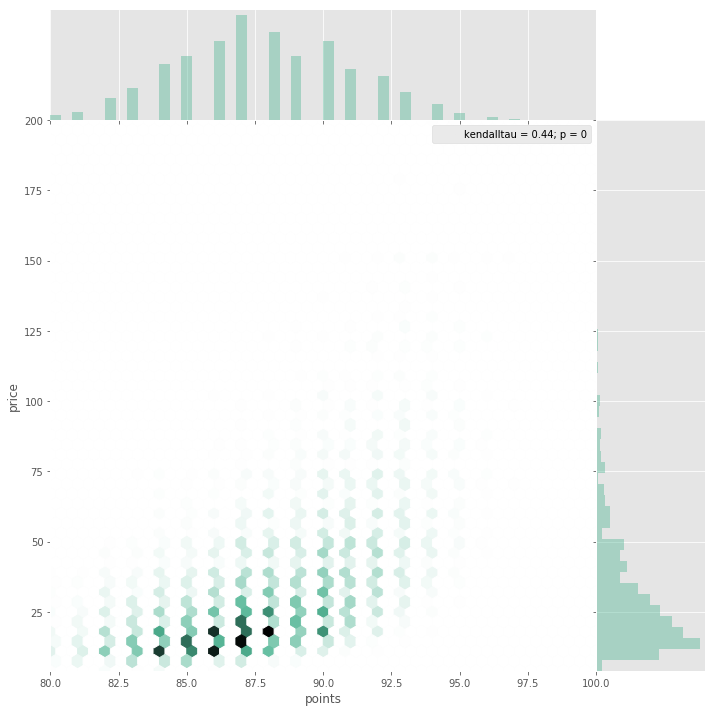

In [11]:
a = data
a = a[a.price <= 200]
sns.jointplot(x='points',y='price',stat_func=kendalltau,kind="hex", color="#4CB391",space=0,size=10,data=a)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


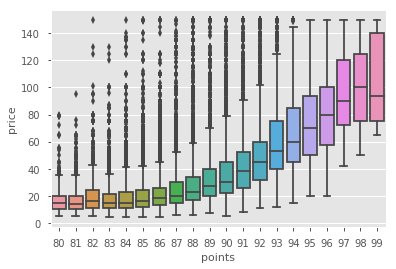

In [30]:
a = data[data.price <= 150][data.points < 100]
sns.boxplot(x = 'points', y = 'price', data = a)

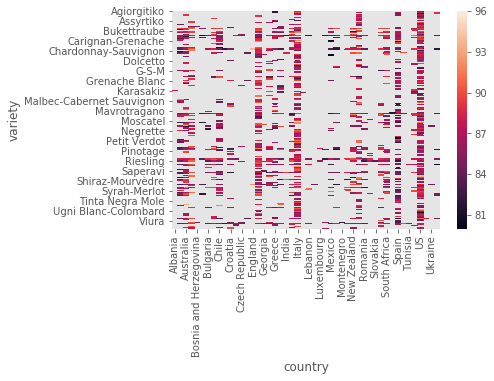

In [7]:
wines = data.pivot_table(values='points',index=['variety'],columns=['country'],aggfunc='mean')
wines.head()
sns.heatmap(wines)

In [8]:
df = data.sample(n=9000)
df = df[['description','Good']]
df.head()

,description,Good
16402,The addition of 5% Grenache and 4% Viognier—ro...,0
41332,"The union of Pinotage, Cabernet, Shiraz and Me...",1
115406,"A gorgeous wine, soft as old kid leather, with...",1
143881,A blend of fruit from Yarra Valley—where the w...,0
40627,"Dark-colored wine, with smoky, bitter chocolat...",1


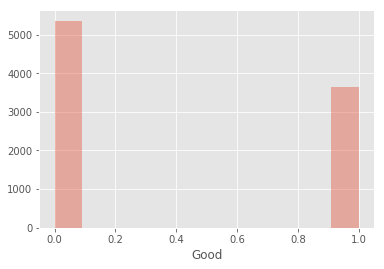

In [9]:
sns.distplot(df.Good, kde=False)

In [10]:
def split_into_lemmas(message):
    message = str(message).lower()
    words = TextBlob(message).words
    return [word.lemma for word in words]

BOW_transform = CountVectorizer(analyzer=split_into_lemmas).fit(df['description'])

In [11]:
BOW = BOW_transform.transform(df['description'])

In [12]:
tfidf_BOW = TfidfTransformer().fit(BOW)

In [13]:
print('inverse document frequnency of the word "to" is:', tfidf_BOW.idf_[BOW_transform.vocabulary_['fruit']])

inverse document frequnency of the word "to" is: 1.87851748628


In [14]:
converted_messages = tfidf_BOW.transform(BOW)

In [15]:
t1 = dt.datetime.now()
spam_detector = MultinomialNB().fit(converted_messages, df['Good'])
t2 = dt.datetime.now()
print('total time taken in training:', (t2-t1))

total time taken in training: 0:00:00.007334


In [16]:
#print('predicted:', spam_detector.predict(tfidf_BOW.transform(BOW[120]))[0])
#print('expected:', df['Good'][120])

In [17]:
target = np.array(df['Good'].tolist())
features = converted_messages
skf = StratifiedKFold(target, n_folds=5)

In [18]:
true_ = []
pred_ = []
for train_index, test_index in skf:
    spam_detector = MultinomialNB().fit(converted_messages[train_index], target[train_index])
    predict = spam_detector.predict(converted_messages[test_index])
    true_.append(target[test_index])
    pred_.append(predict)

In [19]:
TrueLabel = list(itertools.chain(*true_))
PredictedLabel = list(itertools.chain(*pred_))

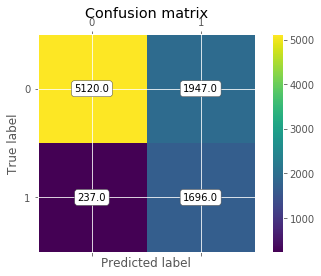

In [20]:
cm = confusion_matrix(PredictedLabel, TrueLabel)
fig, ax = plt.subplots()
im = ax.matshow(cm)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    
plt.title('Confusion matrix')
fig.colorbar(im)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [21]:
TrueLabel = [1 if x==1 else 0 for x in TrueLabel]
PredictedLabel = [1 if x==1 else 0 for x in PredictedLabel]

In [22]:
print('Correlation between the actual and prediction is:', pearsonr(TrueLabel, PredictedLabel)[0], 'with p-value',  ("%.2f" % pearsonr(TrueLabel, PredictedLabel)[1]))

Correlation between the actual and prediction is: 0.503567704375 with p-value 0.00


In [23]:
target_names = ['Good Wine', 'Bad Wine']
print(classification_report(TrueLabel, PredictedLabel, target_names=target_names))

             precision    recall  f1-score   support

  Good Wine       0.72      0.96      0.82      5357
   Bad Wine       0.88      0.47      0.61      3643

avg / total       0.79      0.76      0.74      9000



In [24]:

print('Area under the curve (AUC) is:', roc_auc_score(TrueLabel, PredictedLabel))

Area under the curve (AUC) is: 0.710654595404


In [25]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(TrueLabel, PredictedLabel)
roc_auc = auc(false_positive_rate, true_positive_rate)

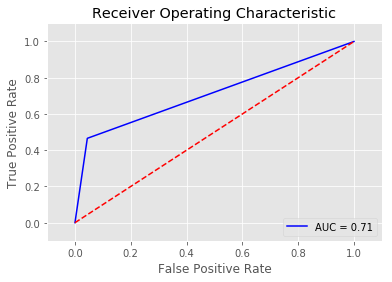

In [26]:
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#Lots of code from
#https://github.com/shubhabrataroy/Thinkful/blob/master/Curriculum/SpamFilter.ipynb

In [31]:
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,Good
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,1
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,1
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,1
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,1
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,1


In [41]:
good = data[data.Good == 1]
bad = data[data.Good == 0]

In [70]:
goodString = ' '.join(good['description'].tolist()).lower()
badString = ' '.join(bad['description'].tolist()).lower()
goodTokens = nltk.tokenize.word_tokenize(goodString)
badTokens = nltk.tokenize.word_tokenize(badString)

In [71]:
goodDist = nltk.FreqDist(goodTokens)
badDist = nltk.FreqDist(badTokens)

In [73]:
stopwords = nltk.corpus.stopwords.words('english')

In [78]:
good_filter = lambda goodDist, stopwords: dict( (word,goodDist[word]) for word in goodDist if word not in stopwords )
good_word_freq = dict_filter(goodDist, stopwords)

In [79]:
bad_filter = lambda goodDist, stopwords: dict( (word,badDist[word]) for word in badDist if word not in stopwords )
bad_word_freq = dict_filter(badDist, stopwords)

In [98]:
Good = pd.DataFrame(list(good_word_freq.items()))
Good.columns = ['word','count']
Bad = pd.DataFrame(list(bad_word_freq.items()))
Bad.columns = ['word','count']

In [106]:
Good.sort_values('count',ascending=False).head(20)

,word,count
20,",",260577
11,.,179042
4,wine,42762
101,'s,32294
54,flavors,28720
14,fruit,26018
24,tannins,17254
32,finish,14535
136,acidity,14204
38,ripe,14151


In [107]:
Bad.sort_values('count',ascending=False).head(20)

,word,count
1,",",287513
13,.,226614
12,flavors,49109
7,wine,47733
14,'s,40422
43,fruit,30488
200,finish,23189
38,aromas,23001
32,acidity,18399
49,palate,18112
